In [210]:
!pip install torcheval

In [211]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torcheval.metrics.text import Perplexity
from torchtext.data.metrics import bleu_score

In [213]:
PATH = '/content/drive/MyDrive/d2l.ai_implementation/datasets/fra-eng/fra.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [214]:
class MTFraEng(Dataset):
    def __init__(self, path, train=True, num_steps=9, num_train=512, num_test=128):
        super(MTFraEng, self).__init__()

        self.num_steps = num_steps

        text = self._get_text(path)
        text = self._preprocess(text)
        src, tgt = self._tokenize(text)

        arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(src, tgt)
        src, tgt, src_valid_len, label = arrays

        if train:
            self.src = src[:num_train]
            self.tgt = tgt[:num_train]
            self.label = label[:num_train]
            self.src_valid_len = src_valid_len[:num_train]
        else:
            self.src = src[num_train:num_train+num_test]
            self.tgt = tgt[num_train:num_train+num_test]
            self.label = label[num_train:num_train+num_test]
            self.src_valid_len = src_valid_len[num_train:num_train+num_test]

    def __getitem__(self, index):
        return (self.src[index], self.tgt[index]), self.label[index]

    def __len__(self):
        return len(self.src)

    def _get_text(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
        text = re.sub('\tCC-BY(.*)', '', text)
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
            for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples:
                break
            parts = line.split('\t')
            if len(parts) == 2:
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt

    def _build_arrays(self, src, tgt):
        def _build_array(sentences, is_tgt=False):
            pad_or_trim = lambda seq, max_len: seq[:max_len] if len(seq) > max_len else seq + ['<pad>'] * (max_len - len(seq))

            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]

            vocab = build_vocab_from_iterator(sentences, min_freq=2, specials=["<unk>"])
            vocab.set_default_index(vocab['<unk>'])
            array = torch.tensor([vocab.lookup_indices(s) for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len

        src_array, src_vocab, src_valid_len = _build_array(src)
        tgt_array, tgt_vocab, _ = _build_array(tgt, is_tgt=True)
        return (src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]), src_vocab, tgt_vocab

In [215]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers=num_layers, dropout=dropout)

    def forward(self, X):
        #X : (batch size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        #embs : (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        #outputs : (num_steps, batch_size, num_hidden)
        #state : (num_layers, batch_size, num_hidden)
        return outputs, state

In [216]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(num_hiddens, vocab_size)

    def forward(self, X, state):
        embs = self.embedding(X.t().type(torch.int64))
        #embs : (num_steps, batch_size, embed_size)
        enc_outputs, enc_state = state
        context = enc_outputs[-1].repeat(embs.shape[0], 1, 1)
        #context : (num_steps, batch_size, num_hidden)
        embs_with_context = torch.cat((embs, context), dim=2)
        #embs_with_context : (num_steps, batch_size, embed_size + num_hidden)
        outputs, state = self.rnn(embs_with_context, enc_state)
        outputs = self.fc(outputs).swapaxes(0, 1)
        return outputs, (enc_outputs, state)

In [217]:
class EncoderDecoder(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_hiddens, num_layers, dropout):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder(src_vocab_size, embed_size, num_hiddens, num_layers, dropout)
        self.decoder = Decoder(tgt_vocab_size, embed_size, num_hiddens, num_layers, dropout)

    def forward(self, enc_X, dec_X):
        enc_outputs = self.encoder(enc_X)
        return self.decoder(dec_X, enc_outputs)[0]

In [218]:
def train_run_epoch(model, device, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for (src, tgt), label in train_loader:
        src, tgt, label = src.to(device), tgt.to(device), label.to(device)

        output = model(src, tgt)

        output = output.reshape(-1, output.size()[2])
        label = label.flatten()
        loss = loss_fn(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [219]:
def test_run_epoch(model, device, test_loader, loss_fn):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for (src, tgt), label in train_loader:
            src, tgt, label = src.to(device), tgt.to(device), label.to(device)

            output = model(src, tgt)

            output = output.reshape(-1, output.size()[2])
            label = label.flatten()
            loss = loss_fn(output, label)

            total_loss += loss.item()

        avg_loss = total_loss / len(test_loader)

    return avg_loss

In [220]:
def train(model, device, train_loder, test_loader, optimizer, loss_fn, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(1, num_epochs+1):

        train_loss = train_run_epoch(model, device, train_loader, optimizer, loss_fn)
        train_losses.append(train_loss)

        test_loss = test_run_epoch(model, device, test_loader, loss_fn)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch}/{num_epochs}]")
        print(f"Train Loss = {train_loss:.20f}")
        print(f"Test Loss = {test_loss:.20f}")
        print()

    return train_losses, test_losses

In [221]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
num_steps=9
batch_size=128
learning_rate = 0.005

In [222]:
train_data = MTFraEng(PATH, train=True, num_steps=num_steps, num_train=20000)
test_data = MTFraEng(PATH, train=False, num_steps=num_steps, num_test=1000)

train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

In [223]:
model = EncoderDecoder(len(train_data.src_vocab), len(train_data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout).to(DEVICE)

In [224]:
def loss(pred, label, tgt_pad, criterion):
    mask = (label != tgt_pad)
    loss = criterion(pred, label)
    return (loss * mask).sum() / mask.sum()

In [225]:
epochs = 50
criterion = nn.CrossEntropyLoss(reduction='none')
loss_fn = lambda pred, label: loss(pred, label, train_data.tgt_vocab['<pad>'], criterion)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [226]:
train_losses, test_losses = train(model, DEVICE, train_loader, test_loader, optimizer, loss_fn, epochs)

Epoch [1/50]
Train Loss = 3.96793901540671178907
Test Loss = 57.80534365773200988770

Epoch [2/50]
Train Loss = 2.77301932444238374842
Test Loss = 44.41209751367568969727

Epoch [3/50]
Train Loss = 2.24906372872127846563
Test Loss = 35.70067290961742401123

Epoch [4/50]
Train Loss = 1.90547394676572956485
Test Loss = 29.85746257007122039795

Epoch [5/50]
Train Loss = 1.64574219846421754276
Test Loss = 25.08674503862857818604

Epoch [6/50]
Train Loss = 1.44861545380513390135
Test Loss = 21.37819930166006088257

Epoch [7/50]
Train Loss = 1.29391051325828398966
Test Loss = 18.63915314525365829468

Epoch [8/50]
Train Loss = 1.17141807724715807382
Test Loss = 17.18571455776691436768

Epoch [9/50]
Train Loss = 1.08455730889253554317
Test Loss = 15.73102109879255294800

Epoch [10/50]
Train Loss = 1.01765401006504219161
Test Loss = 14.13413401693105697632

Epoch [11/50]
Train Loss = 0.96563612693434308643
Test Loss = 13.65387552976608276367

Epoch [12/50]
Train Loss = 0.92116699135227564366
Te

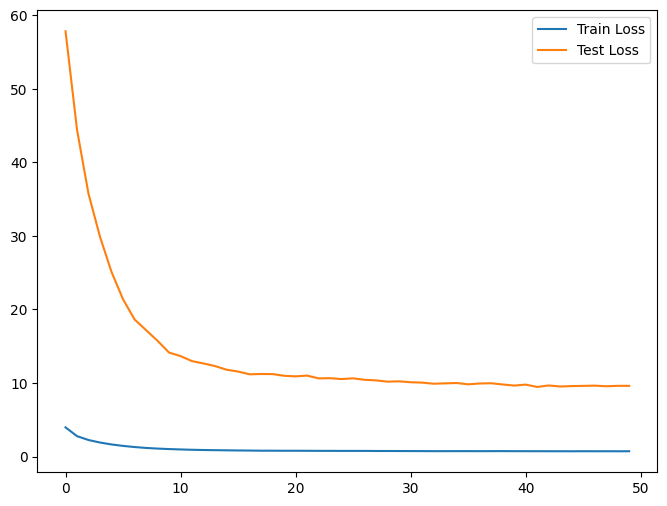

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.show()